In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [26]:
def load_and_prepare_data():
    """Load customer and transaction data from Google Drive links"""
    # Load datasets
    customers_df = pd.read_csv('https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE&export=download')
    products_df = pd.read_csv('https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0&export=download')
    transactions_df = pd.read_csv('https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF&export=download')

    # Convert date columns
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    return customers_df, products_df, transactions_df


In [27]:
def create_customer_features(customers_df, transactions_df, products_df):
    """Create feature matrix for clustering"""
    # Calculate customer age
    customers_df['AccountAge'] = (pd.Timestamp.now() - customers_df['SignupDate']).dt.days

    # One-hot encode region
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='Region')

    # Transaction features
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'Quantity': ['sum', 'mean'],
        'TotalValue': ['sum', 'mean'],
        'Price': 'mean'
    })

    # Flatten column names
    transaction_features.columns = [
        'TransactionCount',
        'TotalQuantity',
        'AvgQuantity',
        'TotalSpend',
        'AvgSpend',
        'AvgPrice'
    ]

    # Fill NaN values
    transaction_features = transaction_features.fillna(0)

    # Calculate purchase frequency (days between purchases)
    purchase_dates = transactions_df.groupby('CustomerID')['TransactionDate'].agg(['min', 'max', 'count'])
    purchase_dates['purchase_frequency'] = (purchase_dates['max'] - purchase_dates['min']).dt.days / purchase_dates['count']
    purchase_dates['purchase_frequency'] = purchase_dates['purchase_frequency'].fillna(0)

    # Product category preferences
    category_pivot = pd.pivot_table(
        transactions_df.merge(products_df[['ProductID', 'Category']], on='ProductID'),
        values='Quantity',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )

    # Normalize category preferences
    category_sums = category_pivot.sum(axis=1)
    category_sums = category_sums.replace(0, 1)
    category_preferences = category_pivot.div(category_sums, axis=0)
    category_preferences.columns = [f'Category_{col}' for col in category_preferences.columns]

    # Combine features
    feature_matrix = pd.concat([
        customers_df[['CustomerID', 'AccountAge']].set_index('CustomerID'),
        region_dummies,
        transaction_features,
        purchase_dates['purchase_frequency'],
        category_preferences
    ], axis=1)

    # Fill any remaining NaN values
    feature_matrix = feature_matrix.fillna(0)

    return feature_matrix


In [28]:
def visualize_clusters(X, labels):
    """Create visualizations for clusters using PCA"""
    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    plot_df['Cluster'] = labels

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Create scatter plot
    sns.scatterplot(
        data=plot_df, x='PC1', y='PC2', hue='Cluster',
        palette=sns.color_palette("husl", len(set(labels))),
        s=100, edgecolor='w', alpha=0.8
    )

    plt.title('Customer Segments Visualization (PCA)', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

    plt.legend(title='Cluster', fontsize=10, title_fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    # Save plot
    plt.savefig('cluster_visualization_enhanced.png')
    plt.close()

    return plot_df


def analyze_clusters(feature_matrix, labels):
    """Analyze characteristics of each cluster"""
    # Add cluster labels to feature matrix
    cluster_df = feature_matrix.copy()
    cluster_df['Cluster'] = labels

    # Calculate cluster profiles
    cluster_profiles = cluster_df.groupby('Cluster').mean()

    return cluster_profiles

Loading data...
Creating customer features...

Finding optimal number of clusters...

Evaluating different numbers of clusters:

N_Clusters | Davies-Bouldin | Silhouette | Calinski-Harabasz
------------------------------------------------------------
    2      |     0.9769     |   0.4644   |      390.90     
    3      |     1.5411     |   0.3314   |      226.16     
    4      |     1.3375     |   0.3217   |      201.06     
    5      |     1.1428     |   0.4432   |      204.50     
    6      |     1.2030     |   0.4516   |      196.38     
    7      |     1.2178     |   0.4528   |      186.83     
    8      |     1.0601     |   0.5752   |      237.88     
    9      |     1.0043     |   0.5882   |      248.39     
    10     |     1.0145     |   0.5863   |      232.66     


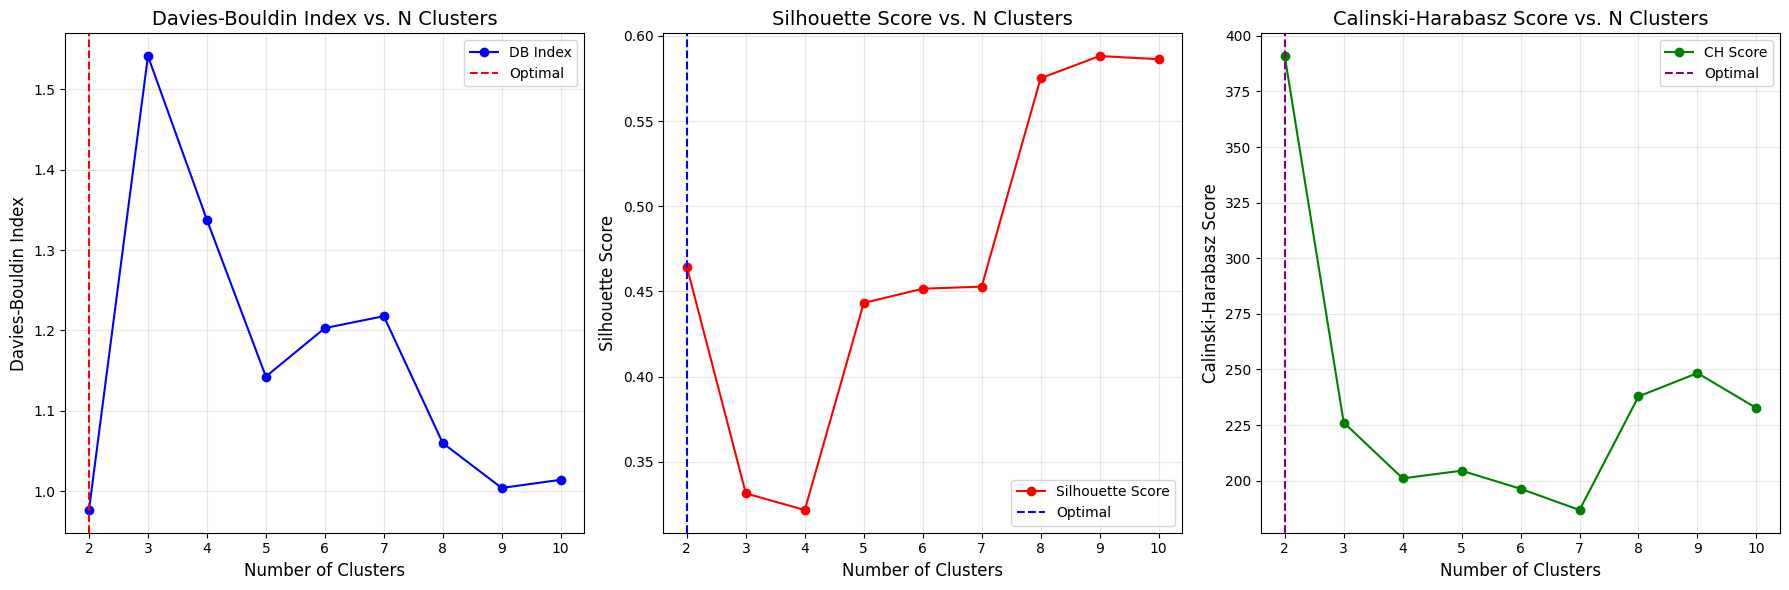


Creating visualizations...


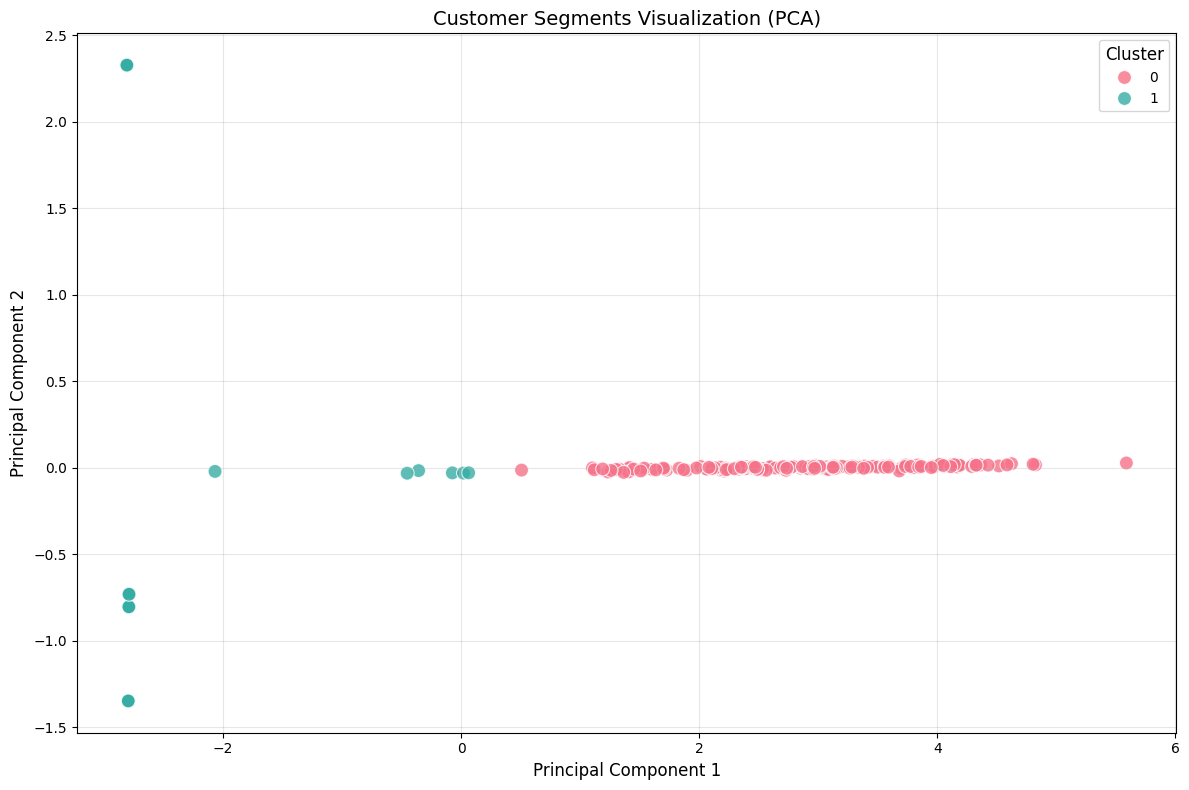


Analyzing clusters...

Cluster Sizes:
Cluster 0: 194 customers
Cluster 1: 206 customers


In [29]:
def find_optimal_clusters(X, max_clusters=10):
    """Find optimal number of clusters using multiple metrics"""
    n_clusters_range = range(2, max_clusters + 1)
    db_scores = []
    silhouette_scores = []
    ch_scores = []

    print("\nEvaluating different numbers of clusters:")
    print("\nN_Clusters | Davies-Bouldin | Silhouette | Calinski-Harabasz")
    print("-" * 60)

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)

        db_score = davies_bouldin_score(X, labels)
        silhouette_avg = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)

        db_scores.append(db_score)
        silhouette_scores.append(silhouette_avg)
        ch_scores.append(ch_score)

        print(f"{n_clusters:^10d} | {db_score:^14.4f} | {silhouette_avg:^10.4f} | {ch_score:^16.2f}")

    # Find optimal number of clusters
    optimal_n_clusters = n_clusters_range[np.argmin(db_scores)]

    # Plot metrics
    plt.figure(figsize=(18, 6))

    # Davies-Bouldin Index
    plt.subplot(1, 3, 1)
    plt.plot(n_clusters_range, db_scores, 'bo-', label='DB Index')
    plt.axvline(optimal_n_clusters, color='r', linestyle='--', label='Optimal')
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Davies-Bouldin Index', fontsize=12)
    plt.title('Davies-Bouldin Index vs. N Clusters', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)

    # Silhouette Score
    plt.subplot(1, 3, 2)
    plt.plot(n_clusters_range, silhouette_scores, 'ro-', label='Silhouette Score')
    plt.axvline(optimal_n_clusters, color='b', linestyle='--', label='Optimal')
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Score vs. N Clusters', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)

    # Calinski-Harabasz Score
    plt.subplot(1, 3, 3)
    plt.plot(n_clusters_range, ch_scores, 'go-', label='CH Score')
    plt.axvline(optimal_n_clusters, color='purple', linestyle='--', label='Optimal')
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Calinski-Harabasz Score', fontsize=12)
    plt.title('Calinski-Harabasz Score vs. N Clusters', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.savefig('clustering_metrics_enhanced.png')
    plt.close()

    return optimal_n_clusters, db_scores, silhouette_scores, ch_scores


def perform_clustering():
    """Main function to perform customer segmentation"""
    print("Loading data...")
    customers_df, products_df, transactions_df = load_and_prepare_data()

    print("Creating customer features...")
    feature_matrix = create_customer_features(customers_df, transactions_df, products_df)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(feature_matrix)

    print("\nFinding optimal number of clusters...")
    optimal_n_clusters, db_scores, silhouette_scores, ch_scores = find_optimal_clusters(X_scaled)

    # Perform final clustering with optimal number of clusters
    final_kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
    labels = final_kmeans.fit_predict(X_scaled)

    # Visualize clusters
    print("\nCreating visualizations...")
    plot_df = visualize_clusters(X_scaled, labels)

    # Analyze clusters
    print("\nAnalyzing clusters...")
    cluster_profiles = analyze_clusters(feature_matrix, labels)

    # Print final cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    print("\nCluster Sizes:")
    for cluster, count in zip(unique, counts):
        print(f"Cluster {cluster}: {count} customers")

    return {
        'n_clusters': optimal_n_clusters,
        'db_index': min(db_scores),
        'silhouette_score': silhouette_scores[optimal_n_clusters-2],
        'ch_score': ch_scores[optimal_n_clusters-2],
        'labels': labels,
        'cluster_profiles': cluster_profiles,
        'feature_matrix': feature_matrix
    }

# Execute clustering
results = perform_clustering()


Cluster Feature Summary Statistics:
         AccountAge                           Region_Asia                      \
               mean         std   min     max        mean       std min   max   
Cluster                                                                         
0        562.840206  324.653630  30.0  1101.0         0.0  0.000000   0     0   
1         11.349515   84.256138   0.0  1011.0    0.218447  0.414199   0  True   

        Region_Europe            ... Category_Clothing       \
                 mean       std  ...               min  max   
Cluster                          ...                          
0                 0.0  0.000000  ...               0.0  1.0   
1            0.242718  0.429771  ...               0.0  1.0   

        Category_Electronics                     Category_Home Decor  \
                        mean       std  min  max                mean   
Cluster                                                                
0                   0.242

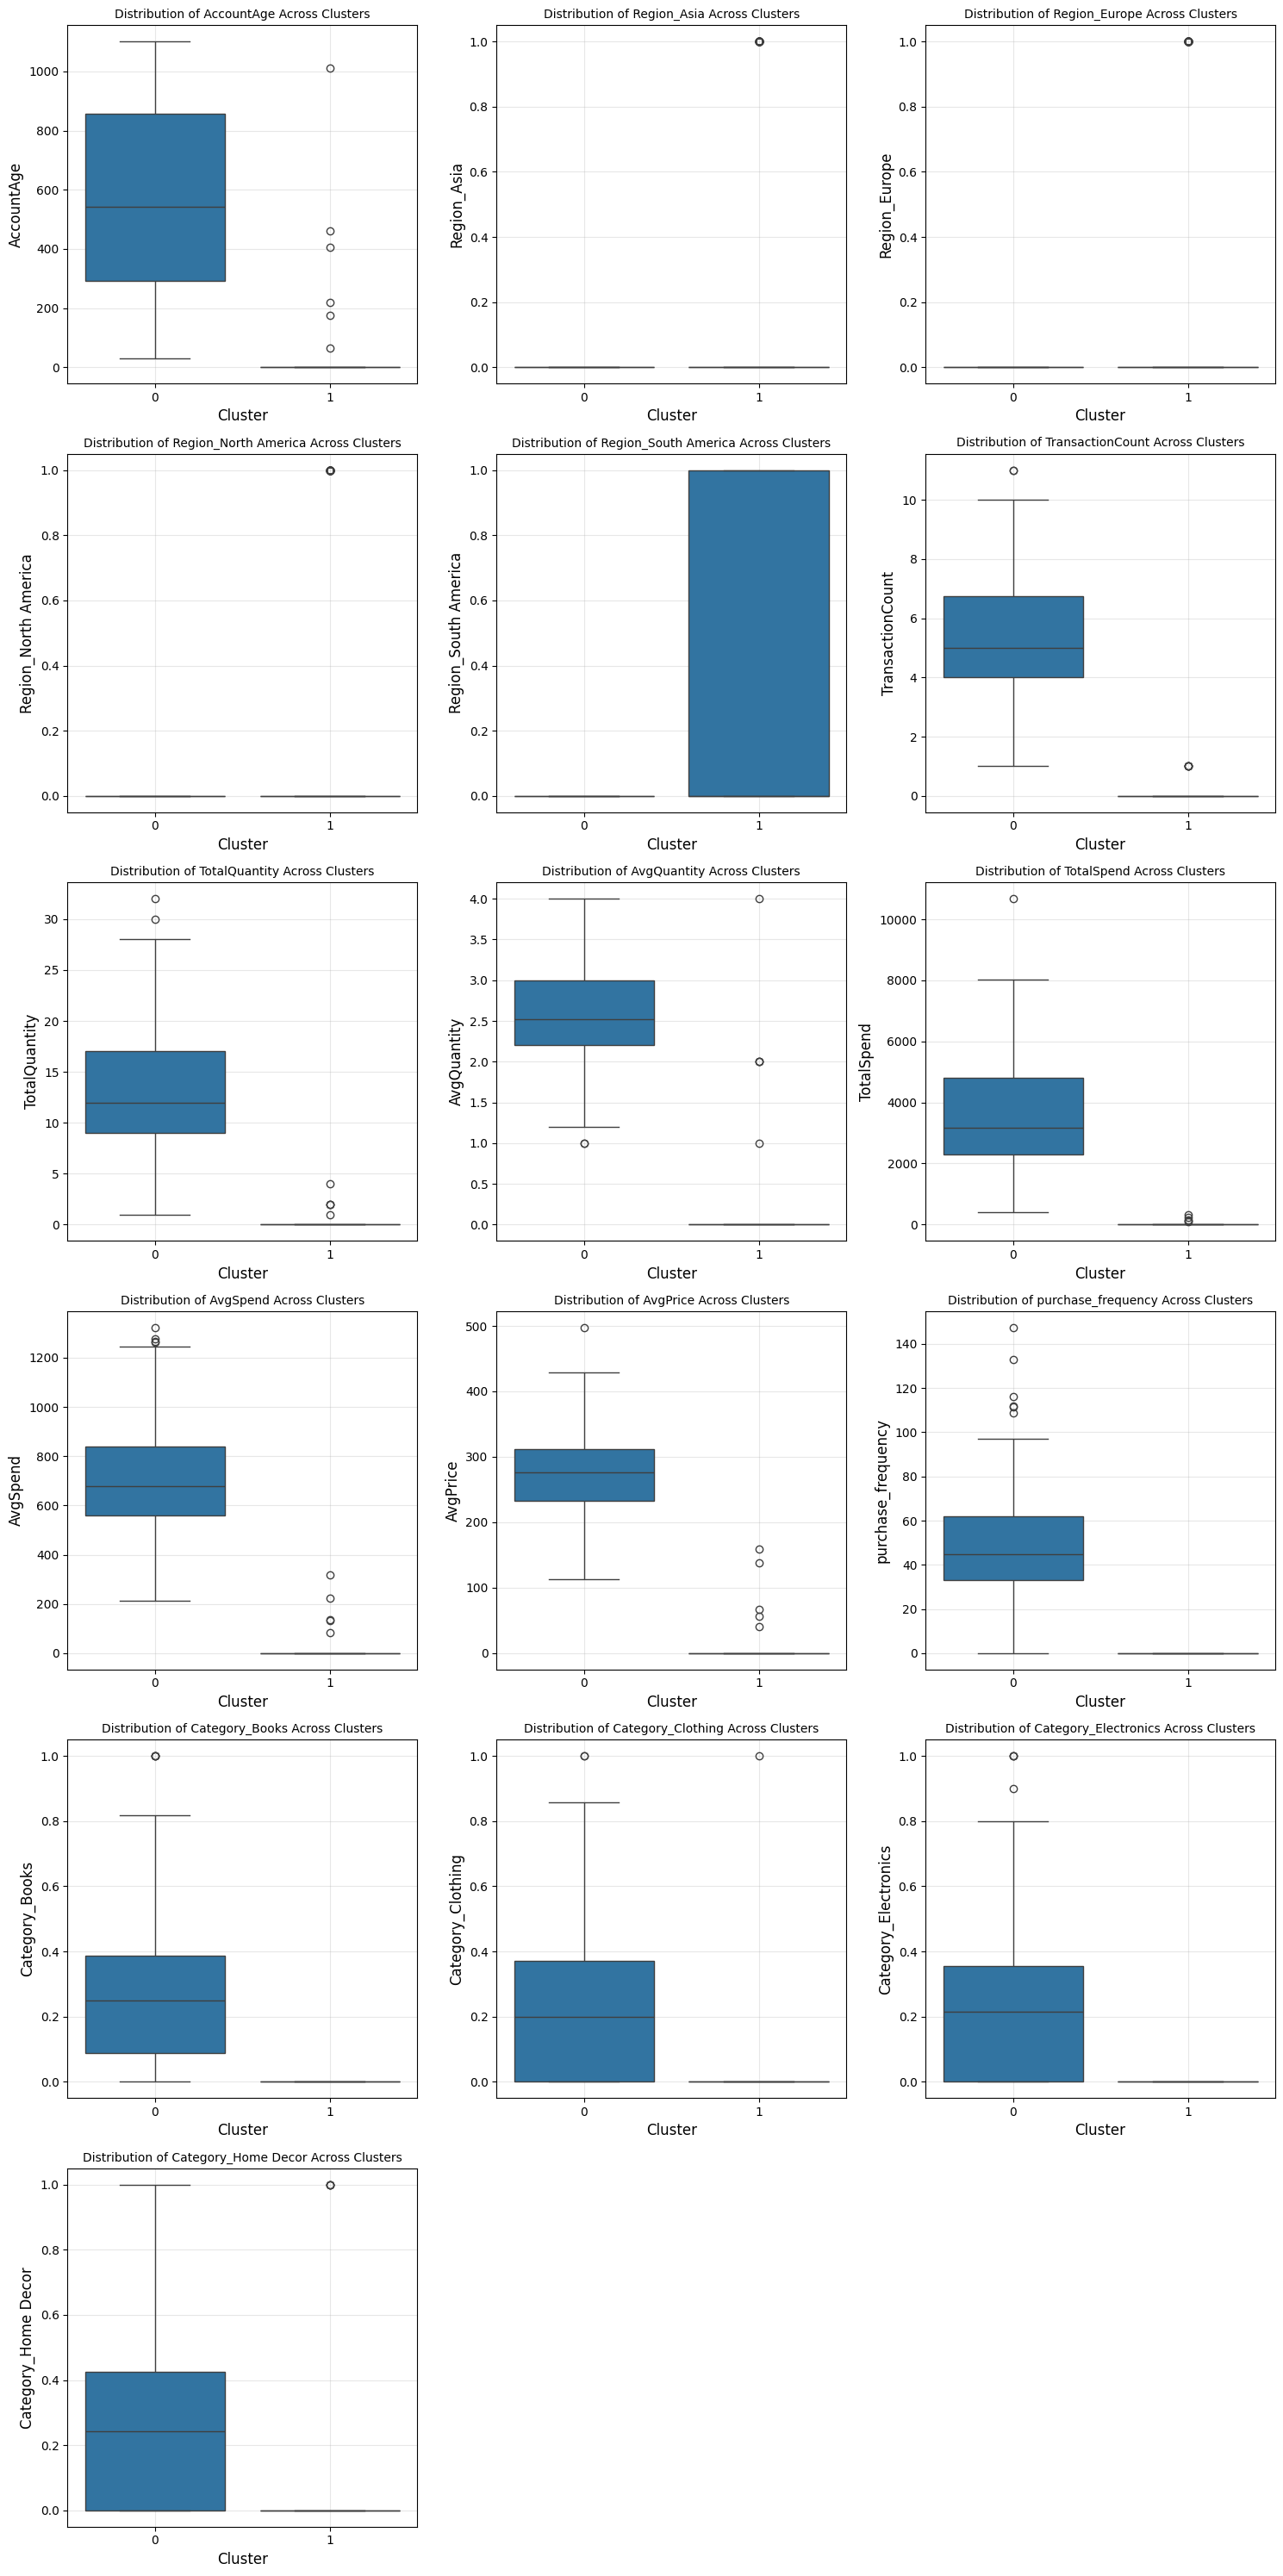

AccountAge                           Region_Asia                      \
               mean         std   min     max        mean       std min   max   
Cluster                                                                         
0        562.840206  324.653630  30.0  1101.0         0.0  0.000000   0     0   
1         11.349515   84.256138   0.0  1011.0    0.218447  0.414199   0  True   

        Region_Europe            ... Category_Clothing       \
                 mean       std  ...               min  max   
Cluster                          ...                          
0                 0.0  0.000000  ...               0.0  1.0   
1            0.242718  0.429771  ...               0.0  1.0   

        Category_Electronics                     Category_Home Decor  \
                        mean       std  min  max                mean   
Cluster                                                                
0                   0.242655  0.226076  0.0  1.0            0.257686   
1                   0.000000  0.000000  0.0  0.0            0.019417   

                             
              std  min  max  
Cluster                      
0        0.239335  0.0  1.0  
1        0.138323  0.0  1.0  

[2 rows x 64 columns]

In [30]:
def analyze_features_by_cluster(feature_matrix, labels):
    """Analyze different features for each cluster with grid layout visualization"""
    # Add cluster labels to the feature matrix
    feature_matrix_with_labels = feature_matrix.copy()
    feature_matrix_with_labels['Cluster'] = labels

    # Compute summary statistics for each cluster
    cluster_analysis = feature_matrix_with_labels.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

    # Display a summary of statistics
    print("\nCluster Feature Summary Statistics:")
    print(cluster_analysis)

    # Set up the grid for the plots
    num_features = len(feature_matrix.columns)
    num_rows = (num_features // 3) + 1  # 3 plots per row (adjust as needed)
    num_cols = 3  # Number of columns in the grid

    # Create the grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    # Loop through features and create box plots
    for i, feature in enumerate(feature_matrix.columns):
        ax = axes[i]
        sns.boxplot(x='Cluster', y=feature, data=feature_matrix_with_labels.reset_index(), ax=ax)
        ax.set_title(f'Distribution of {feature} Across Clusters', fontsize=10)
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel(feature, fontsize=12)
        ax.grid(alpha=0.3)

    # Hide unused subplots if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    return cluster_analysis

analyze_features_by_cluster(results['feature_matrix'] , results['labels'] )